# Домашняя работа

В директории /var/datasets/wikipedia_info/ вам даны данные из википедии.
Создайте Structured Streaming поток, который считывает данные из директории /var/datasets/wikipedia_info/, токенизирует их и удалить стоп слова, а затем записывает в папку /user/jupyter-$<ваш юзернейм>/

In [1]:
import os

print(f"Мой юзернейм: {os.environ.get('USER')}")

Мой юзернейм: jupyter-admin


В папке hdfs /var/datasets/wikipedia_info/ лежит датасет для обработки

In [2]:
# Датасет для обработки
!hdfs dfs -ls /var/datasets/wikipedia_info/

Found 135 items
-rw-r--r--   1 jupyter-admin hadoop        416 2022-04-28 12:23 /var/datasets/wikipedia_info/1.json
-rw-r--r--   1 jupyter-admin hadoop        365 2022-04-28 12:23 /var/datasets/wikipedia_info/10.json
-rw-r--r--   1 jupyter-admin hadoop        959 2022-04-28 12:23 /var/datasets/wikipedia_info/100.json
-rw-r--r--   1 jupyter-admin hadoop       3626 2022-04-28 12:23 /var/datasets/wikipedia_info/101.json
-rw-r--r--   1 jupyter-admin hadoop        317 2022-04-28 12:23 /var/datasets/wikipedia_info/102.json
-rw-r--r--   1 jupyter-admin hadoop        772 2022-04-28 12:23 /var/datasets/wikipedia_info/103.json
-rw-r--r--   1 jupyter-admin hadoop        666 2022-04-28 12:23 /var/datasets/wikipedia_info/104.json
-rw-r--r--   1 jupyter-admin hadoop        919 2022-04-28 12:23 /var/datasets/wikipedia_info/105.json
-rw-r--r--   1 jupyter-admin hadoop       1058 2022-04-28 12:23 /var/datasets/wikipedia_info/106.json
-rw-r--r--   1 jupyter-admin hadoop        623 2022-04-28 12:23 /var/

# Локальные тесты

Ниже пример обработки данных на локальных файлах:

In [3]:
# Данные выглядят следующим образом
import json

with open('Wikipedia_info/1.json', 'r') as f:
    data = json.load(f)
data

{'car_name': 'audi A1',
 'info': 'The Audi A1 (internally designated Typ 8X) is a supermini car launched by Audi at the 2010 Geneva Motor Show. Sales of the initial three-door A1 model started in Germany in August 2010, with the United Kingdom following in November 2010.[2] A five-door version, called Sportback, was launched in November 2011, with sales starting in export markets during spring 2012.'}

In [4]:
# Будем использовать библиотеку nltk для токенизации
# pip install nltk
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /home/jupyter-
[nltk_data]     admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jupyter-
[nltk_data]     admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Токенизация
data['tokenized_info'] = [word for word in word_tokenize(data['info']) if not word in stopwords.words('english')]

In [6]:
print(data['tokenized_info'])

['The', 'Audi', 'A1', '(', 'internally', 'designated', 'Typ', '8X', ')', 'supermini', 'car', 'launched', 'Audi', '2010', 'Geneva', 'Motor', 'Show', '.', 'Sales', 'initial', 'three-door', 'A1', 'model', 'started', 'Germany', 'August', '2010', ',', 'United', 'Kingdom', 'following', 'November', '2010', '.', '[', '2', ']', 'A', 'five-door', 'version', ',', 'called', 'Sportback', ',', 'launched', 'November', '2011', ',', 'sales', 'starting', 'export', 'markets', 'spring', '2012', '.']


In [7]:
def tokenizer(row):
    return [word for word in word_tokenize(row) if not word in stopwords.words('english')]

In [8]:
print(tokenizer(data['info']))

['The', 'Audi', 'A1', '(', 'internally', 'designated', 'Typ', '8X', ')', 'supermini', 'car', 'launched', 'Audi', '2010', 'Geneva', 'Motor', 'Show', '.', 'Sales', 'initial', 'three-door', 'A1', 'model', 'started', 'Germany', 'August', '2010', ',', 'United', 'Kingdom', 'following', 'November', '2010', '.', '[', '2', ']', 'A', 'five-door', 'version', ',', 'called', 'Sportback', ',', 'launched', 'November', '2011', ',', 'sales', 'starting', 'export', 'markets', 'spring', '2012', '.']


# Spark Streaming

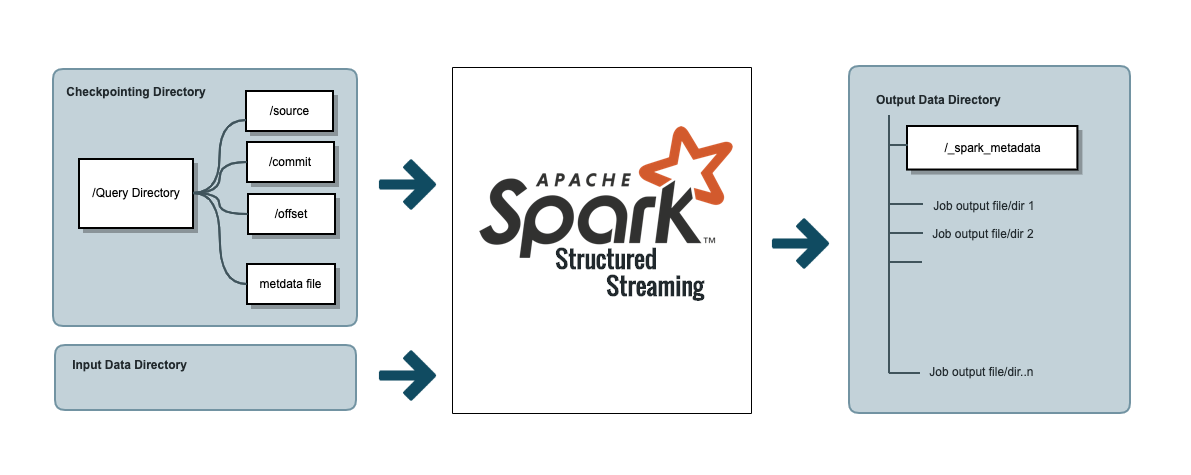

In [9]:
import sys
import os
from pathlib import Path

import findspark
findspark.init()
findspark.find()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *


# os.environ['PYSPARK_PYTHON'] = '../venv/bin/python'

spark = SparkSession.builder \
    .appName("Spark Streaming") \
    .master('local[*]') \
    .config("spark.driver.extraJavaOptions", "-Dcom.sun.net.ssl.checkRevocation=false") \
    .config("spark.executor.extraJavaOptions", "-Dcom.sun.net.ssl.checkRevocation=false") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:3.2.1") \
    .config("spark.sql.streaming.forceDeleteTempCheckpointLocation", "true") \
    .config("spark.executor.instances", "1") \
    .config("spark.executor.memory", "512mb") \
    .getOrCreate()

def kill_all():
    streams = SparkSession.builder.getOrCreate().streams.active
    if streams:
        for stream in streams:
            desc = stream.lastProgress["sources"][0]["description"]
            stream.stop()
            print("Stopped {s}".format(s=desc))

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Ivy Default Cache set to: /home/jupyter-admin/.ivy2/cache
The jars for the packages stored in: /home/jupyter-admin/.ivy2/jars
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-98f154ca-da15-4dd5-8f7c-1bddc87f7c43;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;3.2.1 in central
	found org.apache.spark#spark-token-provider-kafka-0-10

In [10]:
# spark.stop()

In [11]:
spark

In [12]:
path = '/var/datasets/wikipedia_info/'

In [13]:
spark.read.option("multiline", "true").json(path + '/1.json').show()

+--------+--------------------+
|car_name|                info|
+--------+--------------------+
| audi A1|The Audi A1 (inte...|
+--------+--------------------+



In [14]:
spark.read.option("multiline", "true").json(path + '/1.json').schema

StructType(List(StructField(car_name,StringType,true),StructField(info,StringType,true)))

In [15]:
df = spark.read.option("multiline", "true").json(path)
df.show()

+--------------------+-------------------+--------------------+
|     _corrupt_record|           car_name|                info|
+--------------------+-------------------+--------------------+
|                null|       toyota Camry|The Toyota Camry ...|
|                null|           ford Ka+|Developed by Ford...|
|                null|        toyota GT86|The production To...|
|ID,CAR_NAME,FILE_...|               null|                null|
|                null|        ford Escort|The North America...|
|                null|            audi S4|The Audi S4 is th...|
|                null|       ford Mustang|The Ford Mustang ...|
|                null|       toyota Supra|The Toyota Supra ...|
|                null|       toyota Prius|The Toyota Prius ...|
|                null| mercedes CLC Class|The SportCoupé wa...|
|                null|   mercedes E Class|The Mercedes-Benz...|
|                null|        ford Fusion|The Ford Fusion i...|
|                null|   mercedes S Clas

In [16]:
schema = StructType(
      [
        StructField("car_name", StringType(), True),
        StructField("info", StringType(), True),
      ]
)

sdf_from_json = spark \
    .readStream \
    .option("multiline", "true") \
    .format('json') \
    .schema(schema) \
    .option('maxFilesPerTrigger', '2') \
    .option('path', path) \
    .load()

sdf_from_json.printSchema()

root
 |-- car_name: string (nullable = true)
 |-- info: string (nullable = true)



In [17]:
s = sdf_from_json.writeStream \
    .format("console") \
    .trigger(processingTime="5 seconds") \
    .option("truncate", 'true') \
    .option("numRows", "10")

sink = s.start()

2022-05-25 17:23:20,401 WARN streaming.StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-e09d2392-be54-4754-97c6-b1515ee98ce4. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


In [18]:
sink.stop()

In [21]:
import pyspark
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# ['The', 'Audi', 'A1', '(', 'internally', 'designated', 'Typ', '8X', ')', 'supermini', 'car', 'launched', 'Audi', '2010', 'Geneva', 'Motor', 'Show', '.', 'Sales', 'initial', 'three-door', 'A1', 'model', 'started', 'Germany', 'August', '2010', ',', 'United', 'Kingdom', 'following', 'November', '2010', '.', '[', '2', ']', 'A', 'five-door', 'version', ',', 'called', 'Sportback', ',', 'launched', 'November', '2011', ',', 'sales', 'starting', 'export', 'markets', 'spring', '2012', '.']

udf_tokenizer = udf(tokenizer, returnType=ArrayType(StringType()))

In [22]:
df.show()

+--------------------+-------------------+--------------------+
|     _corrupt_record|           car_name|                info|
+--------------------+-------------------+--------------------+
|                null|       toyota Camry|The Toyota Camry ...|
|                null|           ford Ka+|Developed by Ford...|
|                null|        toyota GT86|The production To...|
|ID,CAR_NAME,FILE_...|               null|                null|
|                null|        ford Escort|The North America...|
|                null|            audi S4|The Audi S4 is th...|
|                null|       ford Mustang|The Ford Mustang ...|
|                null|       toyota Supra|The Toyota Supra ...|
|                null|       toyota Prius|The Toyota Prius ...|
|                null| mercedes CLC Class|The SportCoupé wa...|
|                null|   mercedes E Class|The Mercedes-Benz...|
|                null|        ford Fusion|The Ford Fusion i...|
|                null|   mercedes S Clas

In [ ]:
df.dropna().withColumn('tokens', udf_tokenizer('info')).show()

In [8]:
spark.read.option("multiline", "true").json(path + '/1.json').withColumn('tokens', tokenizer('info')).show()

2022-05-25 16:23:02,049 WARN scheduler.TaskSetManager: Lost task 0.0 in stage 3.0 (TID 3, rc1a-dataproc-d-e998z4fz8my7a5xz.mdb.yandexcloud.net, executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/hadoop/yarn/nm-local-dir/usercache/jupyter-admin/appcache/application_1653322324364_0070/container_1653322324364_0070_01_000002/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/hadoop/yarn/nm-local-dir/usercache/jupyter-admin/appcache/application_1653322324364_0070/container_1653322324364_0070_01_000002/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/hadoop/yarn/nm-local-dir/usercache/jupyter-admin/appcache/application_1653322324364_0070/container_1653322324364_0070_01_000002/pyspark.zip/pyspark/serializers.py", line 223, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/hadoop/yarn/nm-local-dir/usercache/jupyter-admin/appc

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/hadoop/yarn/nm-local-dir/usercache/jupyter-admin/appcache/application_1653322324364_0070/container_1653322324364_0070_01_000002/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/hadoop/yarn/nm-local-dir/usercache/jupyter-admin/appcache/application_1653322324364_0070/container_1653322324364_0070_01_000002/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/hadoop/yarn/nm-local-dir/usercache/jupyter-admin/appcache/application_1653322324364_0070/container_1653322324364_0070_01_000002/pyspark.zip/pyspark/serializers.py", line 223, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/hadoop/yarn/nm-local-dir/usercache/jupyter-admin/appcache/application_1653322324364_0070/container_1653322324364_0070_01_000002/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/hadoop/yarn/nm-local-dir/usercache/jupyter-admin/appcache/application_1653322324364_0070/container_1653322324364_0070_01_000002/pyspark.zip/pyspark/serializers.py", line 212, in _batched
    for item in iterator:
  File "/hadoop/yarn/nm-local-dir/usercache/jupyter-admin/appcache/application_1653322324364_0070/container_1653322324364_0070_01_000002/pyspark.zip/pyspark/worker.py", line 450, in mapper
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/hadoop/yarn/nm-local-dir/usercache/jupyter-admin/appcache/application_1653322324364_0070/container_1653322324364_0070_01_000002/pyspark.zip/pyspark/worker.py", line 450, in <genexpr>
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/hadoop/yarn/nm-local-dir/usercache/jupyter-admin/appcache/application_1653322324364_0070/container_1653322324364_0070_01_000002/pyspark.zip/pyspark/worker.py", line 90, in <lambda>
    return lambda *a: f(*a)
  File "/hadoop/yarn/nm-local-dir/usercache/jupyter-admin/appcache/application_1653322324364_0070/container_1653322324364_0070_01_000002/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_88822/2473264557.py", line 8, in tokenizer
NameError: name 'word_tokenize' is not defined


In [ ]:
kill_all()

In [13]:
cass_big_df = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="users_many", keyspace="keyspace1") \
    .load()

Py4JJavaError: An error occurred while calling o166.load.
: java.lang.ClassNotFoundException: Failed to find data source: org.apache.spark.sql.cassandra. Please find packages at http://spark.apache.org/third-party-projects.html
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:689)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSourceV2(DataSource.scala:743)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:248)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:221)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.ClassNotFoundException: org.apache.spark.sql.cassandra.DefaultSource
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:351)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$5(DataSource.scala:663)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$4(DataSource.scala:663)
	at scala.util.Failure.orElse(Try.scala:224)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:663)
	... 14 more
